## Описание датасета
База данных о детях (их семьях, родителях и т.д.) для ранжирования заявок в детские сады.
Входные данные:

Parents

Has Nurse

Form

Children

Housing

Finance

Social

Health

Выходной параметр:

CLASS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

**Загружаем данные**

In [3]:
data = pd.read_csv('nursery.csv', header=None, sep = ',')
data.columns = ['Parents', 'Has Nurse', 'Form', 'Children', 'Housing', 'Finance', 'Social', 'Health', 'CLASS']

In [4]:
data.head()

,Parents,Has Nurse,Form,Children,Housing,Finance,Social,Health,CLASS
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


**Приведем данные к надлежащему виду**

In [5]:
X = pd.get_dummies(data.drop('CLASS', axis=1))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data['CLASS'].unique())
y = le.transform(data['CLASS'])
print(y.shape)

(12960,)


In [6]:
print(data['CLASS'].unique())

['recommend' 'priority' 'not_recom' 'very_recom' 'spec_prior']


**Разбиваем данные на обучающую и тестовую выборки**

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 7)
N_test, _ = X_test.shape

**Обучаем классификатор. Используем стандартный многослойный персептрон**

In [8]:
from sklearn.neural_network import MLPClassifier

In [9]:
mlp_model = MLPClassifier(solver = 'lbfgs', learning_rate='adaptive', activation = 'logistic', random_state = 42465)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42465,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

**Пример:**

In [10]:
X_test.head()
No = 5
sample = X_test[No-1:No]
cl = y_test[No-1:No]
print(sample)
print(cl)

mlp_model.predict(sample)

       Parents_great_pret  Parents_pretentious  Parents_usual  \
10609                   1                    0              0   

       Has Nurse_critical  Has Nurse_improper  Has Nurse_less_proper  \
10609                   0                   1                      0   

       Has Nurse_proper  Has Nurse_very_crit  Form_complete  Form_completed  \
10609                 0                    0              0               1   

              ...          Housing_critical  Housing_less_conv  \
10609         ...                         0                  1   

       Finance_convenient  Finance_inconv  Social_nonprob  Social_problematic  \
10609                   1               0               0                   1   

       Social_slightly_prob  Health_not_recom  Health_priority  \
10609                     0                 0                1   

       Health_recommended  
10609                   0  

[1 rows x 27 columns]
[3]


array([3], dtype=int64)

**Проверим работу классификатора**

In [11]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

_Результат работы на обучающей и тестовой выборке:_

In [12]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

0.999881291548 0.998456790123


In [13]:
print(1 - mlp_model.score(X_test, y_test))

0.00154320987654


_Все хорошо_

**Подбор гиперпараметров**

 _Однако для лучшего результата подберем параметр регуляризации alpha:_

In [14]:
alpha_arr = np.logspace(-3, 2, 10)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

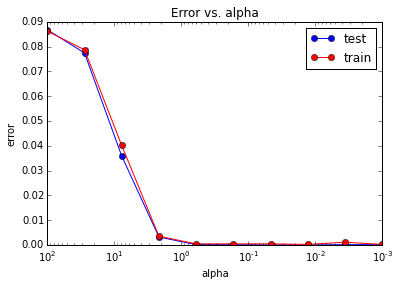

In [15]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

_Минимальное значение ошибки:_

In [16]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.000220458553792


_Оптимальное значение alpha:_

In [17]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[ 0.001      0.0129155]


In [18]:
alpha_opt = alpha_opt[0]

**Классификатор с оптимальным значением alpha:**

In [19]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.000118708452042
0.000220458553792


**Матрица рассогласования:**

In [20]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[1534    0    0    0    0]
 [   0 1513    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0 1378    0]
 [   0    0    1    0  110]]


C:\Users\Aarven\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


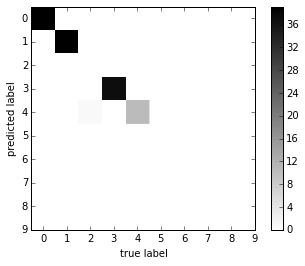

In [21]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

_Другие метрики:_

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1534
          1       1.00      1.00      1.00      1513
          2       0.00      0.00      0.00         1
          3       1.00      1.00      1.00      1378
          4       0.99      1.00      1.00       110

avg / total       1.00      1.00      1.00      4536



C:\Users\Aarven\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Все ошибки:**

In [40]:
for i in range(N_test):
    sample = X_test[i:i+1]
    cl = y_test[i]
    y_pred = mlp_model.predict(sample)[0]
    if y_pred != cl:
        print("Element number: %d" % i)
        print("Predicted class: %d" % y_pred)
        print("Actual class: %d" % cl)
        print()

Element number: 3409
Predicted class: 4
Actual class: 2

